<a href="https://colab.research.google.com/github/sakibchowdhury131/railcop/blob/main/__DFT%2BCNN_test_frame_size_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 4.1 kB/s 
     |████████████████████████████████| 3.0 MB 55.1 MB/s 
     |████████████████████████████████| 2.9 MB 42.8 MB/s 
     |████████████████████████████████| 454 kB 51.2 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(1)

In [3]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import pandas as pd

In [4]:
label0 = pd.read_csv('/content/drive/MyDrive/RailCop/New Files/Sakib/data/label0/Copy of train_1.csv')
label1 = pd.read_csv('/content/drive/MyDrive/RailCop/New Files/Sakib/data/label1/Copy of train_1.csv')
print(label1)

      Sensor1  Sensor2  ...  Sensor2+Sensor4  Sensor1+Sensor2+Sensor3
0           2        9  ...               10                       12
1           4        9  ...                9                       13
2           4        9  ...               11                       15
3           4       11  ...               12                       16
4           2        9  ...               10                       12
...       ...      ...  ...              ...                      ...
5384        3        9  ...               10                       13
5385        3       10  ...               11                       14
5386        4        8  ...                9                       13
5387        3        9  ...               10                       13
5388        3       10  ...               12                       15

[5389 rows x 7 columns]


In [5]:
__fullVector0 = label0['Sensor1+Sensor2+Sensor3'].to_numpy()
__fullVector1 = label1['Sensor1+Sensor2+Sensor3'].to_numpy()


print(__fullVector0.shape)
print(__fullVector1.shape)


(23050,)
(5389,)


In [57]:
__frameSize = 50

## label 0 framing

__numFrames0 = int(__fullVector0.shape[0] / __frameSize)
__frames0 = np.zeros((__numFrames0,__frameSize))
for i in range (0, __numFrames0):
  for j in range (0, __frameSize):
    __frames0[i][j] = __fullVector0[i*__frameSize+j]

In [58]:
## label 1 framing

__numFrames1 = int(__fullVector1.shape[0] / __frameSize)
__frames1 = np.zeros((__numFrames1,__frameSize))
for i in range (0, __numFrames1):
  for j in range (0, __frameSize):
    __frames1[i][j] = __fullVector1[i*__frameSize+j]

In [59]:
__frames0.shape

(461, 50)

In [60]:
__frames1.shape

(107, 50)

In [61]:
__maxFrames = __frames1.shape[0]
__label0 = __frames0[0:__maxFrames, :]
__label1 = __frames1[0:__maxFrames, :]

In [62]:
Y0 = np.zeros(__label0.shape[0])
Y1 = np.ones(__label1.shape[0])
print(Y0.shape)
print(Y1.shape)

(107,)
(107,)


In [63]:
## Applying DFT
## finding Fourier Co-efficients Xn

def get_xn(samples,n):
    L  = len(samples)
    ks = np.arange(0,L,1)
    xn = np.sum(samples*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

In [64]:
## Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2 and 
## multiply the absolute value of the Fourier coefficients by 2, to account for 
## the symetry of the Fourier coefficients above the Nyquest Limit.


def get_xns(samples):
    mag = []
    L = len(samples)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(samples,n))*2)
    return(mag)
mag = get_xns(__frames0[2])

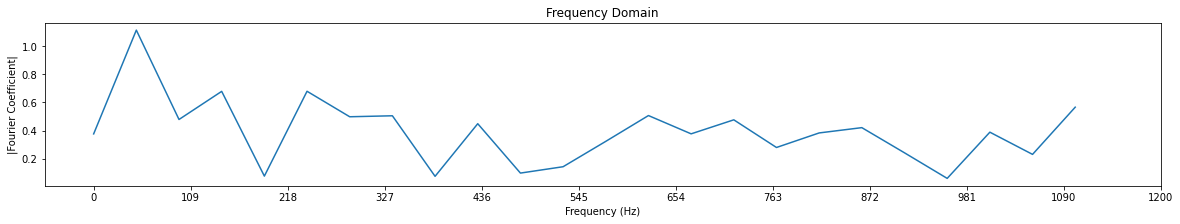

In [65]:
## Fourier Plot 

def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz )
Nxlim = 12
sample_rate = int(9600/4)
ks   = np.linspace(0,len(mag),Nxlim)
ksHz = get_Hz_scale_vec(ks,sample_rate,len(__frames1[0]))

plt.figure(figsize=(20,3))
plt.plot(mag[1:])
plt.xticks(ks,ksHz)
plt.title("Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Fourier Coefficient|")
plt.show()

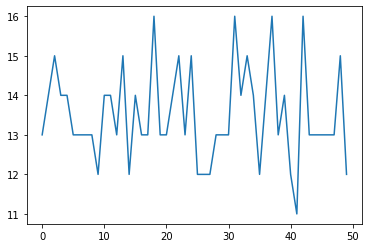

In [66]:
plt.plot (__label1[3])

In [67]:
## Fourier coefficients of label0 
__fourier0 = np.zeros((__maxFrames,len(mag)))
for i in range(0, __maxFrames):
  __fourier0[i] = np.array(get_xns(__label0[i]))



## Fourier coefficients of label1 
__fourier1 = np.zeros((__maxFrames,len(mag)))
for i in range(0, __maxFrames):
  __fourier1[i] = np.array(get_xns(__label1[i]))

In [68]:
X = np.asarray(np.concatenate((__fourier0[:, 1:], __fourier1[:, 1:]), axis = 0), dtype=np.float32)
Y = np.asarray(np.concatenate((Y0, Y1), axis = 0), dtype = np.float32)
print(X.shape)
print(Y.shape)

(214, 24)
(214,)


In [69]:
from sklearn.utils import shuffle
X, Y = shuffle(X,Y)

In [70]:
X.shape

(214, 24)

In [71]:
def network():
  __input = keras.Input((X.shape[1], 1))
  __conv1 = keras.layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(__input)
  __conv2 = keras.layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(__conv1)
  __dense3 = keras.layers.Dense(16, activation = 'relu')(__conv2)
  __flat4 = keras.layers.Flatten()(__dense3)
  __output = keras.layers.Dense(1, activation = 'sigmoid')(__flat4)

  model = keras.Model(inputs = __input, outputs = __output)
  return model 



model = network()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 22, 16)            64        
                                                                 
 conv1d_9 (Conv1D)           (None, 20, 16)            784       
                                                                 
 dense_8 (Dense)             (None, 20, 16)            272       
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 321       
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable p

In [72]:
model.compile(loss='binary_crossentropy',
                      optimizer= 'adam',
                      metrics=['accuracy'])

In [ ]:
__modelVersion = '__timeSeriesTest1.0'

weight_saver = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/RailCop/New Files/Sakib/models/'+__modelVersion, monitor='val_accuracy', 
                                save_best_only=True, save_weights_only=False, mode= 'max')

annealer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001,mode= 'min')


hist = model.fit( x = X , 
                  y = Y, 
                  batch_size = 4,
                  epochs = 600,
                  callbacks = [weight_saver , annealer],
                  validation_split = 0.2,
                  shuffle = True,
                  verbose = 1)

Epoch 1/600
43/43 [==============================] - 2s 39ms/step - loss: 0.6935 - accuracy: 0.4912 - val_loss: 0.6954 - val_accuracy: 0.4419 - lr: 0.0010
Epoch 2/600
43/43 [==============================] - 1s 32ms/step - loss: 0.6893 - accuracy: 0.5497 - val_loss: 0.6912 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 3/600
43/43 [==============================] - 1s 34ms/step - loss: 0.6846 - accuracy: 0.6082 - val_loss: 0.6875 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 4/600
43/43 [==============================] - 0s 4ms/step - loss: 0.6781 - accuracy: 0.6023 - val_loss: 0.6797 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 5/600
43/43 [==============================] - 2s 39ms/step - loss: 0.6698 - accuracy: 0.6257 - val_loss: 0.6671 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 6/600
43/43 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6901 - val_loss: 0.6709 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 7/600
43/43 [==============================] - 1s 33ms/step - loss